In [26]:
# ================================
# 1) Import & Load (GitHub/local only)
# ================================
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import precision_score, recall_score, confusion_matrix

DATA_PATH = Path("data/bs140513_032310.csv")

if not DATA_PATH.exists():
    raise FileNotFoundError(
        "Missing data/bs140513_032310.csv — place the dataset under the 'data/' folder (see data/README.md)."
    )

df = pd.read_csv(DATA_PATH, low_memory=False)
print("Loaded file:", DATA_PATH)


Saving bs140513_032310.csv to bs140513_032310 (2).csv


In [27]:
# ================================
# 2) Quick examination
# ================================
print("Dataset shape (rows, columns):", df.shape)
print(df.head(10))

missing_values = df.isnull().sum()
print("\nMissing values per column:\n", missing_values)

duplicate_rows = int(df.duplicated().sum())
print(f"\nNumber of duplicate rows: {duplicate_rows}")

print("\nData types:\n", df.dtypes)

print("\nNumber of unique values per column:\n", df.nunique(dropna=False).sort_values())

Dataset shape (rows, columns): (594643, 10)
   step       customer  age gender zipcodeOri       merchant zipMerchant  \
0     0  'C1093826151'  '4'    'M'    '28007'   'M348934600'     '28007'   
1     0   'C352968107'  '2'    'M'    '28007'   'M348934600'     '28007'   
2     0  'C2054744914'  '4'    'F'    '28007'  'M1823072687'     '28007'   
3     0  'C1760612790'  '3'    'M'    '28007'   'M348934600'     '28007'   
4     0   'C757503768'  '5'    'M'    '28007'   'M348934600'     '28007'   
5     0  'C1315400589'  '3'    'F'    '28007'   'M348934600'     '28007'   
6     0   'C765155274'  '1'    'F'    '28007'   'M348934600'     '28007'   
7     0   'C202531238'  '4'    'F'    '28007'   'M348934600'     '28007'   
8     0   'C105845174'  '3'    'M'    '28007'   'M348934600'     '28007'   
9     0    'C39858251'  '5'    'F'    '28007'   'M348934600'     '28007'   

              category  amount  fraud  
0  'es_transportation'    4.55      0  
1  'es_transportation'   39.68      0  

In [28]:
# ============================================
# Block 3 — Minimal cleaning + gender normalization
# ============================================

# drop ZIP columns at the start of the block (both are constant)
df = df.drop(columns=['zipcodeOri', 'zipMerchant'])
print("Dropped constant ZIP columns: zipcodeOri, zipMerchant")

# 1) strip quotes/whitespace in relevant text columns
text_cols = ['customer','age','gender','merchant','category']
for c in text_cols:
    df[c] = (
        df[c].astype(str)
             .str.strip()
             .str.strip("'")
             .str.strip('"')
    )

# 2) normalize categories
df['gender']   = df['gender'].str.lower().replace({'e':'unknown', 'u':'unknown'})
df.loc[~df['gender'].isin(['m','f','unknown']), 'gender'] = 'unknown'
df['category'] = df['category'].str.lower()

# 3) convert 'age' -> numeric (nullable Int64) — may create NaN/<NA> for non-numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce').astype('Int64')

# 4) derive temporal features from 'step'
df['day']  = (df['step'] // 24).astype(int)
df['hour'] = (df['step'] % 24).astype(int)

# --- sanity check
print("Shape:", df.shape)
print("Missing values per column:")
print(df.isna().sum().sort_values(ascending=False))

Dropped constant ZIP columns: zipcodeOri, zipMerchant
Shape: (594643, 10)
Missing values per column:
age         1178
step           0
customer       0
gender         0
merchant       0
category       0
amount         0
fraud          0
day            0
hour           0
dtype: int64


In [29]:
# ============================================
# Block 3B — Fill NaNs discovered + sentinel
# ============================================

# create a flag (1 if age was missing)
df['age_unknown'] = df['age'].isna().astype('int64')

# fill 'age' with sentinel -1 (keep Int64)
df['age'] = df['age'].fillna(-1).astype('Int64')

# quick sanity check after fill
print("\nNaN in 'age' AFTER fill:", int(df['age'].isna().sum()))


NaN in 'age' AFTER fill: 0



Class balance:
    fraud   count  percent
0      0  587443   98.789
1      1    7200    1.211


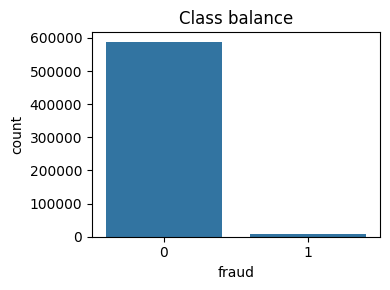


Categorical percent distributions by fraud (within-category %):


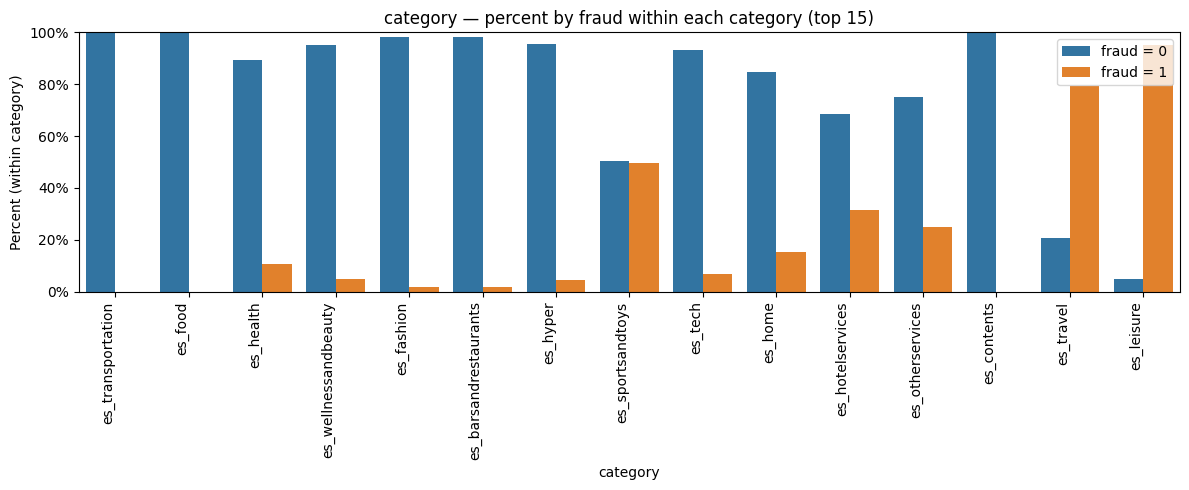

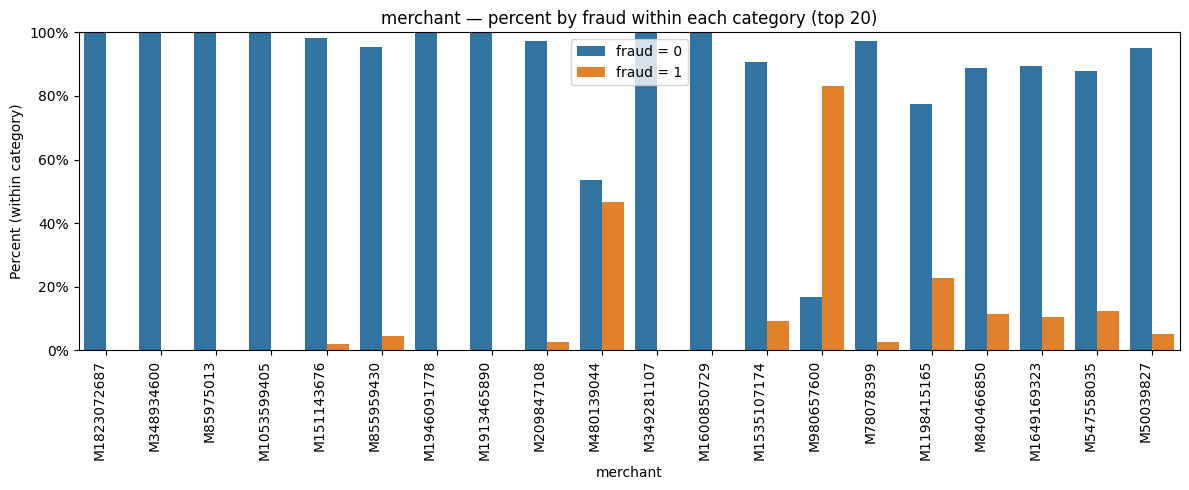

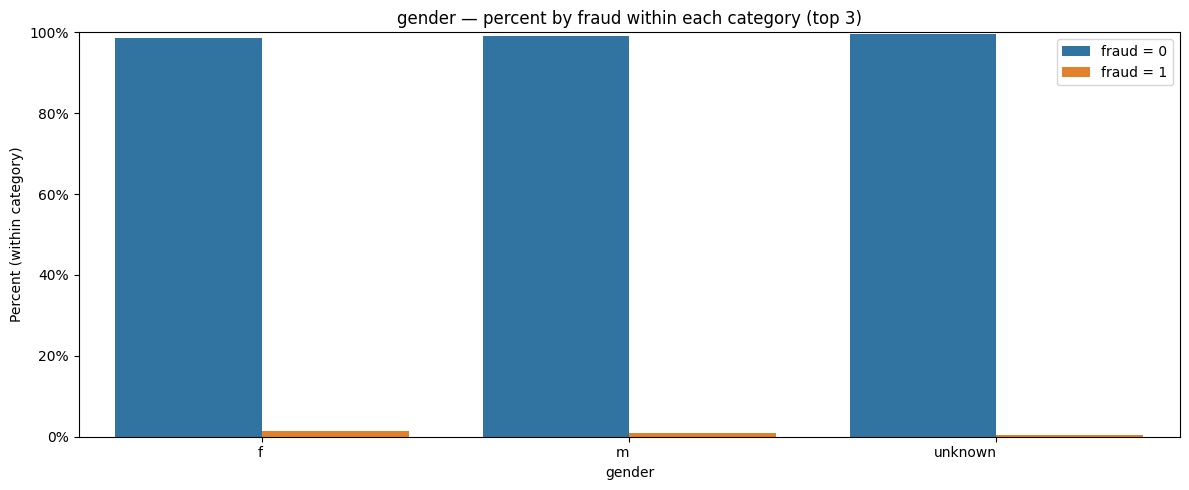

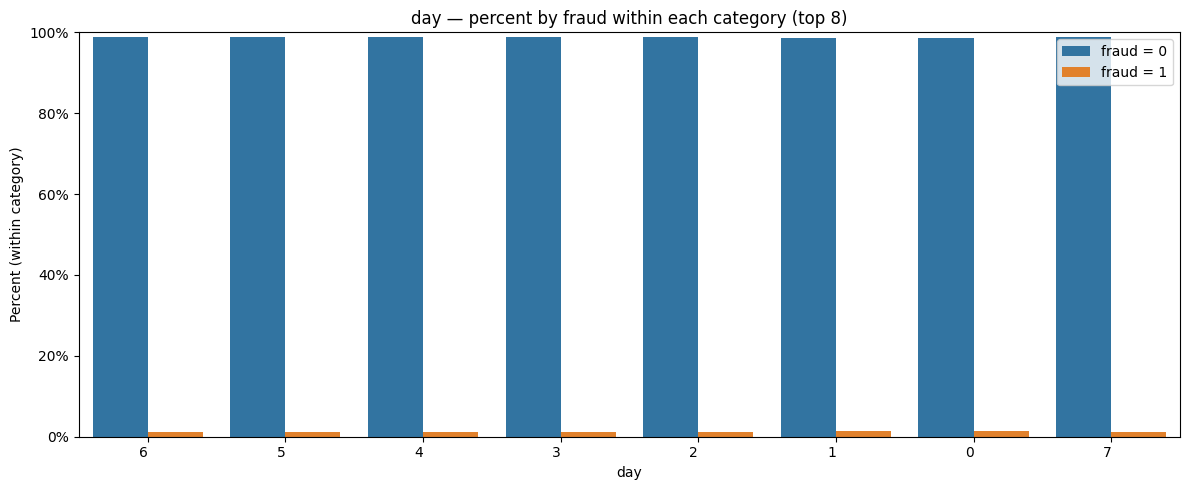

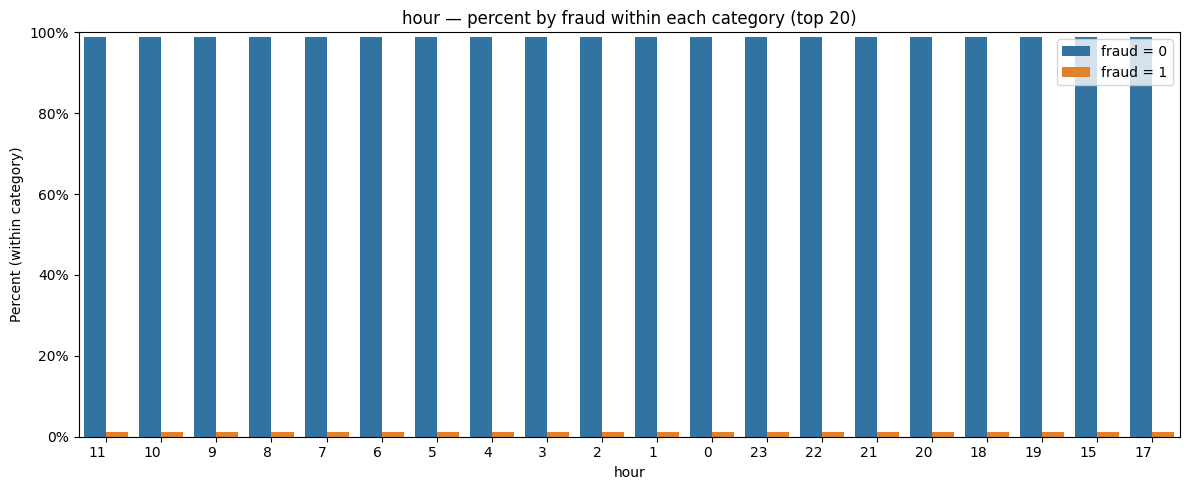

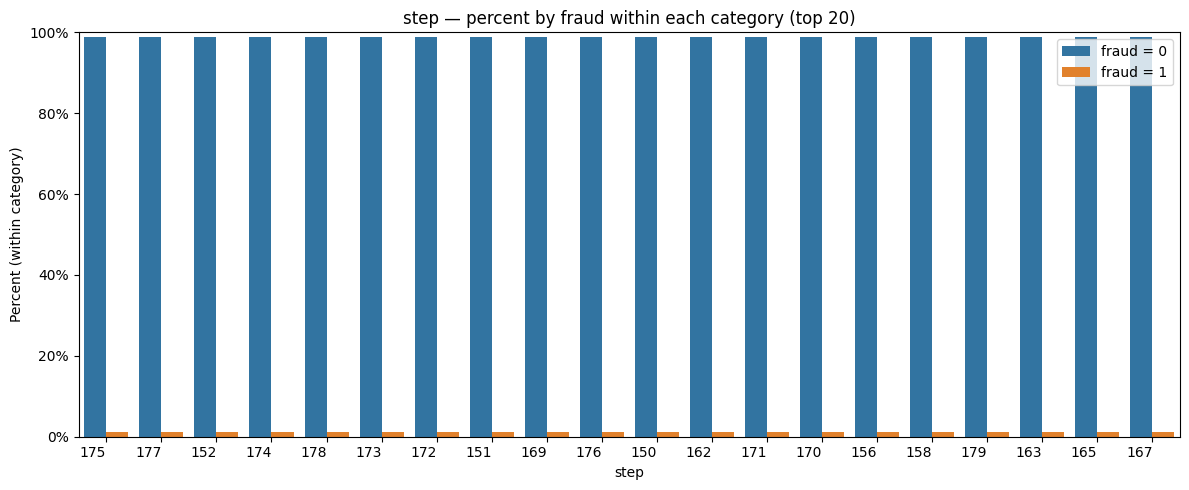


Numeric distributions by fraud:


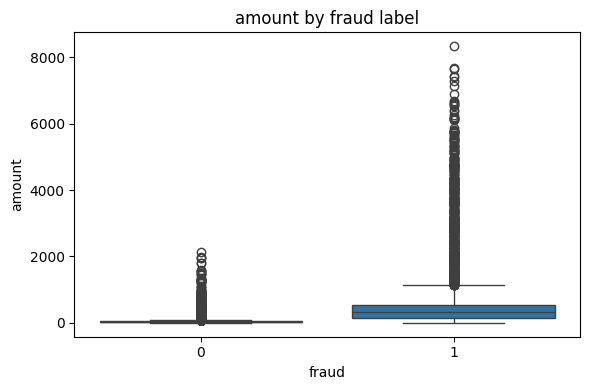

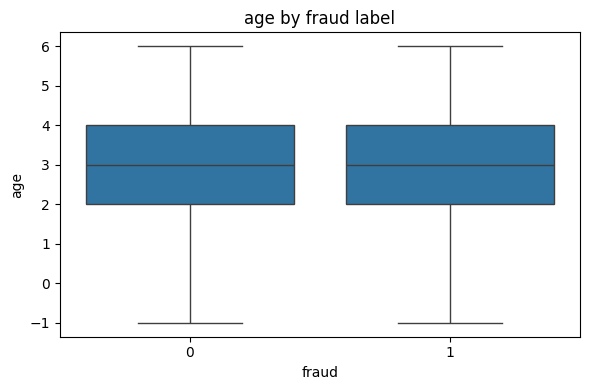


=== CATEGORICAL SUMMARIES (top rows) ===

--- Summary for: category ---
           category_value  n_total  n_fraud  fraud_rate_pct  \
0              es_leisure      499      474          94.990   
1               es_travel      728      578          79.396   
2        es_sportsandtoys     4002     1982          49.525   
3        es_hotelservices     1744      548          31.422   
4        es_otherservices      912      228          25.000   
5                 es_home     1986      302          15.206   
6               es_health    16133     1696          10.513   
7                 es_tech     2370      158           6.667   
8    es_wellnessandbeauty    15086      718           4.759   
9                es_hyper     6098      280           4.592   
10  es_barsandrestaurants     6373      120           1.883   
11             es_fashion     6454      116           1.797   

    share_of_all_frauds_pct  
0                     6.583  
1                     8.028  
2                

/tmp/ipython-input-2679830790.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(value_bin)['fraud']
/tmp/ipython-input-2679830790.py:126: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(value_bin)['fraud']


In [30]:
# ================================
# 4) EDA
# ================================
def pct(x):
    return (x * 100).round(3)

# Class balance
class_balance = pd.concat(
    [df['fraud'].value_counts().rename('count'),
     pct(df['fraud'].value_counts(normalize=True)).rename('percent')],
    axis=1
).rename_axis('fraud').reset_index()
print("\nClass balance:\n", class_balance)

plt.figure(figsize=(4,3))
sns.barplot(data=class_balance, x='fraud', y='count')
plt.title('Class balance')
plt.tight_layout()
plt.show()

# global plotting params (single source of truth)
CATEGORICAL_FIGSIZE = (12, 5)
NUMERIC_FIGSIZE     = (6, 4)
TOP_N               = 20

# columns to plot
categorical_columns = ['category', 'merchant', 'gender', 'day', 'hour', 'step']
numeric_columns     = ['amount', 'age']

# convert day/hour to string for categorical plotting consistency
df['day']  = df['day'].astype(str)
df['hour'] = df['hour'].astype(str)


# plotting: percent within category (0..100)
def plot_categorical_distribution_percent(df, column):
    """
    For each value in `column`, compute percent of fraud vs non-fraud relative to that category's total,
    then plot percent bars (0-100).
    """
    order = df[column].astype(str).value_counts().index[:TOP_N]
    sub = df[df[column].astype(str).isin(order)].copy()
    sub[column] = sub[column].astype(str)

    # pivot: counts per (category value, fraud)
    pivot = sub.groupby([column, 'fraud']).size().unstack(fill_value=0)

    # ensure both columns 0 and 1 exist (robustness)
    for c in [0, 1]:
        if c not in pivot.columns:
            pivot[c] = 0

    # percent within category (rows sum to 100)
    pivot_percent = pivot.div(pivot.sum(axis=1), axis=0).multiply(100)
    pivot_percent = pivot_percent.reset_index().melt(id_vars=column, value_vars=[0,1],
                                                     var_name='fraud', value_name='percent')
    if column == 'merchant' or column == 'category':
        XTICKS_ROTATION = 90
    else:
        XTICKS_ROTATION = 0

    plt.figure(figsize=CATEGORICAL_FIGSIZE)
    sns.barplot(data=pivot_percent, x=column, y='percent', hue='fraud', order=order)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100))
    handles, lbls = plt.gca().get_legend_handles_labels()
    plt.legend(handles=handles, labels=[f"fraud = {l}" for l in lbls], title='')
    plt.title(f"{column} — percent by fraud within each category (top {len(order)})")
    plt.xlabel(column)
    plt.ylabel("Percent (within category)")
    plt.xticks(rotation=XTICKS_ROTATION, ha='right')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


def plot_numeric_by_fraud(df, column):
    """
    Simple numeric boxplot grouped by fraud.
    The caller should decide which numeric columns to pass (e.g., 'amount_for_plot' for log10(amount)).
    """
    plt.figure(figsize=NUMERIC_FIGSIZE)
    sns.boxplot(data=df, x='fraud', y=column)
    plt.title(f"{column} by fraud label")
    plt.xlabel("fraud")
    plt.ylabel(column)
    plt.tight_layout()
    plt.show()


def summary_categorical_table(df, column):
    """
    Summary table for a categorical column (only categories with n_fraud > 0).
    Returns columns: category_value, n_total, n_fraud, fraud_rate_pct, share_of_all_frauds_pct.
    """
    total_frauds = df['fraud'].sum()

    summary_df = (
        df.groupby(column)['fraud']
          .agg(n_total='count', n_fraud='sum')
          .reset_index()
    )

    # keep only categories that actually contain frauds
    summary_df = summary_df[summary_df['n_fraud'] > 0]

    summary_df['fraud_rate_pct'] = (summary_df['n_fraud'] / summary_df['n_total'] * 100).round(3)
    summary_df['share_of_all_frauds_pct'] = (
        (summary_df['n_fraud'] / total_frauds * 100)
        .replace([np.inf, np.nan], 0)
        .round(3)
    )

    summary_df = summary_df.sort_values('fraud_rate_pct', ascending=False).rename(columns={column: 'category_value'}).reset_index(drop=True)
    return summary_df


def summary_numeric_binned_table(df, column):
    """
    Bin numeric column into `bins` and return summary table (only bins with n_fraud > 0).
    Returns columns: value_bin, n_total, n_fraud, fraud_rate_pct, share_of_all_frauds_pct.
    """
    value_bin = pd.qcut(df[column], q=4)
    total_frauds = df['fraud'].sum()

    summary_df = (
        df.groupby(value_bin)['fraud']
          .agg(n_total='count', n_fraud='sum')
          .reset_index()
          .rename(columns={'index': 'value_bin'})
    )

    # keep only bins that contain >=1 fraud
    summary_df = summary_df[summary_df['n_fraud'] > 0]

    summary_df['fraud_rate_pct'] = (summary_df['n_fraud'] / summary_df['n_total'] * 100).round(3)
    summary_df['share_of_all_frauds_pct'] = (
        (summary_df['n_fraud'] / total_frauds * 100)
        .replace([np.inf, np.nan], 0)
        .round(3)
    )

    summary_df = summary_df.sort_values('fraud_rate_pct', ascending=False).reset_index(drop=True)
    return summary_df


# Run categorical plots
print("\nCategorical percent distributions by fraud (within-category %):")
for col in categorical_columns:
    plot_categorical_distribution_percent(df, col)

# Run numeric plots
print("\nNumeric distributions by fraud:")
for col in numeric_columns:
    plot_numeric_by_fraud(df, col)

# Run categorical summaries for each categorical column
print("\n=== CATEGORICAL SUMMARIES (top rows) ===")
for col in categorical_columns:
    print(f"\n--- Summary for: {col} ---")
    cat_summary = summary_categorical_table(df, col)   # returns DataFrame (only categories with n_fraud > 0)
    print(cat_summary.head(20))                      # show top-20 rows

# Run numeric binned summaries for each numeric column
print("\n=== NUMERIC BINNED SUMMARIES (top rows) ===")
for col in numeric_columns:
    print(f"\n--- Binned summary for: {col} ---")
    num_summary = summary_numeric_binned_table(df, col)
    print(num_summary.head(20))

In [31]:
# ================================
# 5) Feature “alerts”
# ================================
label_column = 'fraud'
global_fraud_rate = df[label_column].mean()
print(f"\nGlobal fraud rate: {global_fraud_rate*100:.3f}%")


category_stats = df.groupby('category')[label_column].agg(count='count', frauds='sum')
category_stats['rate'] = category_stats['frauds']/category_stats['count']
category_stats['lift'] = category_stats['rate']/global_fraud_rate
print(category_stats['lift'].rename('lift').rename_axis('category').reset_index().to_string(index=False))


merchant_stats = df.groupby('merchant')[label_column].agg(count='count', frauds='sum')
merchant_stats['rate'] = merchant_stats['frauds']/merchant_stats['count']
merchant_stats['lift'] = merchant_stats['rate']/global_fraud_rate
print(merchant_stats['lift'].rename('lift').rename_axis('merchant').reset_index().to_string(index=False))



# risky sets by lift + minimum support
min_support = 200
min_lift = 2.0

high_lift_categories = category_stats.query("count >= @min_support and lift >= @min_lift").index.tolist()

high_lift_merchants = merchant_stats.query("count >= @min_support and lift >= @min_lift").index.tolist()

print(f"Risky sets — categories: {len(high_lift_categories)} | merchants: {len(high_lift_merchants)}")

# amount thresholds
amount_q99_global = df['amount'].quantile(0.99)
category_amount_q95    = df.groupby('category')['amount'].quantile(0.95)
category_amount_q90    = df.groupby('category')['amount'].quantile(0.90)

# chronological order + behavioral features (burst, first-time)
df = df.sort_values(['customer','step']).reset_index(drop=True)
df['ft_mer'] = df.groupby(['customer','merchant']).cumcount() == 0

cust_step = df.groupby(['customer','step']).size().rename('cust_step_n').reset_index()
cust_step = cust_step.sort_values(['customer','step']).reset_index(drop=True)
cust_step['cust_prev6_n'] = (
    cust_step.groupby('customer')['cust_step_n']
             .transform(lambda s: s.shift().rolling(6, min_periods=1).sum())
).fillna(0).astype(int)
df = df.merge(cust_step, on=['customer','step'], how='left')

# deviation from customer's median amount
tiny_eps = 1e-9
df['cust_median_amount'] = df.groupby('customer')['amount'].transform('median').fillna(0)
df['amt_over_cust_median'] = df['amount'] / (df['cust_median_amount'] + tiny_eps)
amount_deviation_threshold = max(df['amt_over_cust_median'].quantile(0.99), 5.0)

# vectorized masks
mask_amount_above_global_q99 = df['amount'] > amount_q99_global
mask_amount_above_category_q95    = df['amount'] > df['category'].map(category_amount_q95).fillna(np.inf)
mask_amount_above_category_q90    = df['amount'] > df['category'].map(category_amount_q90).fillna(np.inf)

mask_high_lift_category  = df['category'].isin(high_lift_categories)
mask_high_lift_merchant  = df['merchant'].isin(high_lift_merchants)

mask_first_time_merchant_for_customer  = df['ft_mer']
mask_amount_deviates_from_customer_median  = df['amt_over_cust_median'] > amount_deviation_threshold

# burst (6 steps) - threshold by 0.99 quantile
burst_quantile = 0.99
burst_threshold_count = int(max(2, np.nanquantile(df['cust_prev6_n'], burst_quantile)))
mask_customer_burst  = df['cust_prev6_n'] >= burst_threshold_count
print(f"[Burst] threshold: >= {burst_threshold_count} (q={burst_quantile})")

# deterministic rules
df['rule_amount_grtr_global_q99']     = mask_amount_above_global_q99
df['rule_amount_grtr_category_q95'] = mask_amount_above_category_q95
df['rule_high_lift_category']    = mask_high_lift_category
df['rule_high_lift_merchant']    = mask_high_lift_merchant
df['rule_customer_burst6']       = mask_customer_burst
df['rule_age_missing']       = (df['age_unknown'] == 1)

# AND/OR rules
df['rule_high_merchant_high_amount'] = mask_high_lift_merchant & (df['amount'] >= 50)
df['rule_high_category_and_amount'] = mask_high_lift_category & (df['amount'] >= 42.54)
df['rule_high_cat_or_mer_and_amount'] = (mask_high_lift_category | mask_high_lift_merchant) & (df['amount'] >= 55)
df['rule_high_risk'] = (mask_high_lift_category | mask_high_lift_merchant) & (mask_amount_above_category_q90 | mask_amount_above_global_q99 | mask_first_time_merchant_for_customer | mask_customer_burst | mask_amount_deviates_from_customer_median)
df['rule_high_lift_amount_behavior'] = ((mask_high_lift_category | mask_high_lift_merchant) & (mask_amount_above_category_q95 | mask_amount_above_global_q99) & (mask_first_time_merchant_for_customer | mask_customer_burst | mask_amount_deviates_from_customer_median))



Global fraud rate: 1.211%
             category      lift
es_barsandrestaurants  1.555110
          es_contents  0.000000
           es_fashion  1.484406
              es_food  0.000000
            es_health  8.682295
              es_home 12.558897
     es_hotelservices 25.951227
             es_hyper  3.792228
           es_leisure 78.451565
     es_otherservices 20.647326
     es_sportsandtoys 40.902550
              es_tech  5.505954
    es_transportation  0.000000
            es_travel 65.572278
 es_wellnessandbeauty  3.930739
   merchant      lift
M1053599405  0.000000
 M117188757  0.000000
M1198415165 18.713273
M1294758098 79.562472
M1313686961  0.000000
M1352454843  0.000000
M1353266412 67.765584
M1400236507  0.000000
M1416436880  0.000000
 M151143676  1.555110
M1535107174  7.693008
M1600850729  0.000000
M1649169323  8.730668
M1726401631  0.000000
  M17379832 52.130838
M1741626453 30.658151
M1748431652 10.851150
M1788569036  0.000000
M1823072687  0.000000
M1842530320  0.000000

In [32]:
# ================================
# 6) Evaluate rules (precision / recall / lift) using sklearn
# ================================

# label column (set explicitly for reproducibility)
label_column = 'fraud'

y_true = df[label_column].astype(int).to_numpy()
global_fraud_rate = y_true.mean() if len(y_true) else 0.0

def eval_rule_sklearn(y_true, y_pred_series, name):
    """
    y_true: numpy array of 0/1
    y_pred_series: pandas Series boolean/int
    returns dict with rule, flagged, tp, precision, recall, lift
    """
    y_pred = y_pred_series.astype(int).to_numpy()
    flagged = int(y_pred.sum())
    # use zero_division=0 to avoid exceptions when no positive predictions
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    lift = (precision / global_fraud_rate) if global_fraud_rate > 0 else np.nan
    return {
        'rule': name,
        'flagged': flagged,
        'tp': int(tp),
        'precision': round(precision, 4),
        'recall': round(recall, 4),
        'lift': round(lift, 2)
    }

# list of rule columns to evaluate
rule_cols = [
    'rule_amount_grtr_global_q99',
    'rule_amount_grtr_category_q95',
    'rule_high_lift_category',
    'rule_high_lift_merchant',
    'rule_customer_burst6',
    'rule_age_missing',
    'rule_high_merchant_high_amount',
    'rule_high_category_and_amount',
    'rule_high_cat_or_mer_and_amount',
    'rule_high_risk',
    'rule_high_lift_amount_behavior'
]

results = []
for rc in rule_cols:
    results.append(eval_rule_sklearn(y_true, df[rc], rc))

eval_tbl = pd.DataFrame(results).sort_values(['recall', 'precision'], ascending=[False, False]).reset_index(drop=True)
print("\nRule evaluation (sorted by recall, then precision):")
print(eval_tbl)

eval_tbl['score'] = eval_tbl['recall'] * eval_tbl['precision']
top5_rules = eval_tbl.sort_values('score', ascending=False).head(5)

print("\n=== Top 5 Rules by recall*precision score ===")
print(top5_rules)


Rule evaluation (sorted by recall, then precision):
                               rule  flagged    tp  precision  recall   lift
0           rule_high_lift_category    49558  6964     0.1405  0.9672  11.61
1           rule_high_lift_merchant    28752  6642     0.2310  0.9225  19.08
2     rule_high_category_and_amount    33711  6496     0.1927  0.9022  15.91
3   rule_high_cat_or_mer_and_amount    30107  6464     0.2147  0.8978  17.73
4                    rule_high_risk    33646  6317     0.1877  0.8774  15.51
5    rule_high_merchant_high_amount    17539  6100     0.3478  0.8472  28.72
6       rule_amount_grtr_global_q99     5947  4567     0.7680  0.6343  63.42
7    rule_high_lift_amount_behavior     5787  4164     0.7195  0.5783  59.43
8     rule_amount_grtr_category_q95    29722  2138     0.0719  0.2969   5.94
9              rule_customer_burst6     6141  1265     0.2060  0.1757  17.01
10                 rule_age_missing     1178     7     0.0059  0.0010   0.49

=== Top 5 Rules by rec